In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Image Directory

In [27]:
image_dir = Path('/kaggle/input/indian-food-images-dataset/Indian Food Images/Indian Food Images')

# Setting Filepath and Labels

In [28]:
filepath = list(image_dir.glob(r'**/*.jpg'))
label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))

# Converting it into image_df

In [29]:
filepath = pd.Series(filepath, name = 'Filepath').astype(str)
label = pd.Series(label, name = 'Label')
image_df = pd.concat([filepath, label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
image_df.head()

,Filepath,Label
0,/kaggle/input/indian-food-images-dataset/India...,ariselu
1,/kaggle/input/indian-food-images-dataset/India...,unni_appam
2,/kaggle/input/indian-food-images-dataset/India...,chak_hao_kheer
3,/kaggle/input/indian-food-images-dataset/India...,chikki
4,/kaggle/input/indian-food-images-dataset/India...,sandesh


In [30]:
len(image_df['Label'].unique())

80

In [31]:
image_df.shape

(4000, 2)

# Label encoding Food names

In [34]:
le = LabelEncoder()
image_df['Label'] = le.fit_transform(image_df['Label'])
image_df['Label'].value_counts()

7     50
79    50
40    50
69    50
4     50
      ..
59    50
39    50
37    50
32    50
22    50
Name: Label, Length: 80, dtype: int64

# Image Data Generator

#### Creating train_test_split

In [36]:
train_df, test_df = train_test_split(image_df, test_size = 0.30, shuffle = True, random_state = 1)

In [38]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [22]:
train_image = train_gen.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (224,224),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True,
                                           seed = 42,
                                           subset = 'training')
val_image = train_gen.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (224,224),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True,
                                           seed = 42,
                                           subset = 'validation')
test_image = test_gen.flow_from_dataframe(dataframe = test_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (224,224),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = False)

Found 2240 validated image filenames belonging to 80 classes.
Found 560 validated image filenames belonging to 80 classes.
Found 1200 validated image filenames belonging to 80 classes.


# Training

In [40]:
inputs = tf.keras.Input(shape = (120,120,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size =(3,3), activation = 'relu' )(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size =(3,3), activation = 'relu' )(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'mse',
             metrics = ['accuracy'])
history  = model.fit(train_image,
                    validation_data = val_image,
                    epochs = 100,
                    callbacks = [tf.keras.callbacks.EarlyStopping(
                    monitor = 'val_loss',
                    patience = 5,
                    restore_best_weights = True)])

Epoch 1/100
70/70 [==============================] - 30s 421ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy: 0.9875
Epoch 2/100
70/70 [==============================] - 29s 418ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy: 0.9875
Epoch 3/100
70/70 [==============================] - 30s 424ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy: 0.9875
Epoch 4/100
70/70 [==============================] - 29s 408ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy: 0.9875
Epoch 5/100
70/70 [==============================] - 29s 416ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy: 0.9875
Epoch 6/100
70/70 [==============================] - 29s 415ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy: 0.9875
Epoch 7/100
70/70 [==============================] - 29s 410ms/step - loss: 0.0123 - accuracy: 0.9875 - val_loss: 0.0123 - val_accuracy:

Results

In [ ]:
result = model.evaluate(test_image, verbose = 0)
print('Test Loss : {:.3f}'.format(result[0]))
print('Test Accuracy : {:.3f}%'.format(result[1]*100))

# Plotting Training and Validation (Loss & Accuracy)

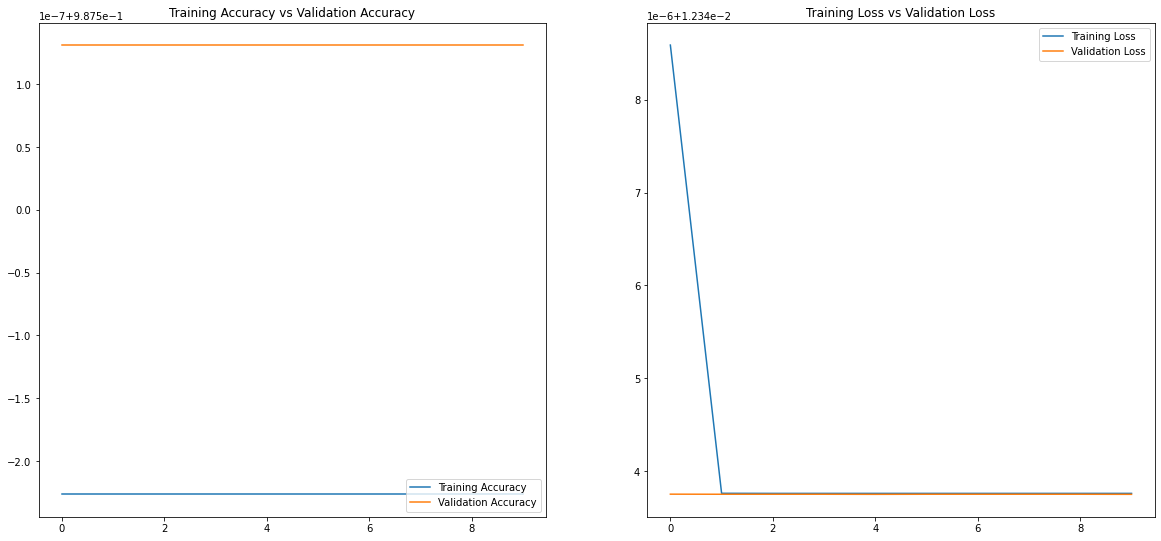

In [50]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(range(10),history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(10), history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend(loc = 'lower right')
plt.subplot(2,2,2)
plt.plot(range(10),history.history['loss'], label = 'Training Loss')
plt.plot(range(10), history.history['val_loss'], label = 'Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend(loc = 'upper right')
plt.show()